In [1]:
print("Configurando o ambiente e a API do Kaggle")
!pip install -q tensorflow_datasets kaggle

import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random

# Configuração da API do Kaggle
from google.colab import files
print("\nPor favor, faça o upload do seu arquivo 'kaggle.json'")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ API do Kaggle configurada!")

Configurando o ambiente e a API do Kaggle

Por favor, faça o upload do seu arquivo 'kaggle.json'


Saving kaggle.json to kaggle.json

✅ API do Kaggle configurada!


In [2]:
# !rm -rf datasets
# !rm -f *.npy

In [3]:
print("Criando todos os datasets via busca de imagens no Bing")

# Instalando e importando as bibliotecas necessárias
!pip install -q bing-image-downloader
from bing_image_downloader import downloader
import os
import shutil


# Definindo os termos de busca e executando o download
search_terms = [
    ('car side view', 'cars'),
    ('wrist watch product shot', 'watches'),
    ('smartphone isolated on white background', 'smartphones'),
    ('gaming headset product shot', 'headphones')
]

for term, folder in search_terms:
    print(f"\n  Processando: {folder}...")
    # Baixa as imagens.
    downloader.download(term,
                        limit=35,
                        output_dir='datasets',
                        adult_filter_off=True,
                        force_replace=False,
                        timeout=60)

    # Renomeia a pasta para o nome padrão
    source_folder = os.path.join('datasets', term)
    destination_folder = os.path.join('datasets', folder)

    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)

    os.rename(source_folder, destination_folder)

    count = len(os.listdir(destination_folder))
    print(f"    -> {count} imagens de '{folder}' baixadas com sucesso.")

print("\n✅ Todos os datasets foram criados com sucesso!")

Criando todos os datasets via busca de imagens no Bing

  Processando: cars...
[%] Downloading Images to /content/datasets/car side view


[!!]Indexing page: 1

[%] Indexed 47 Images on Page 1.


[%] Downloading Image #1 from https://www.wallpaperbetter.com/wallpaper/402/762/548/chevrolet-camaro-red-car-side-view-2K-wallpaper.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://img5.goodfon.com/wallpaper/nbig/e/9b/ferrari-f430-sportkar-superkar-krasnyi-vid-sboku.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://c8.alamy.com/comp/2CFAB5X/small-city-car-side-view-isolated-on-white-2CFAB5X.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://c8.alamy.com/comp/ER3G11/red-city-car-side-view-ER3G11.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://c8.alamy.com/comp/2C8GPRT/family-car-side-view-isolated-on-white-2C8GPRT.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://cdn.suwalls.com/wallpapers/cars/white-lamborghini-aventa

In [4]:
print("Carregando o modelo VGG16 pré-treinado")

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

def preprocess_image(img_path):
    """Carrega e pré-processa uma imagem para o modelo VGG16."""
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

print("✅ Modelo carregado e função de pré-processamento definida!")

Carregando o modelo VGG16 pré-treinado
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Modelo carregado e função de pré-processamento definida!


In [5]:
print("Extraindo características das imagens (com limite para carros)")

all_features = {}
all_image_paths = {}
categories = ['cars', 'watches', 'smartphones', 'headphones']

for category in categories:
    features_path = f'{category}_features.npy'
    paths_path = f'{category}_paths.npy'

    # Recriar o cache de 'cars' por causa da mudança de lógica
    if category == 'cars':
        !rm -f cars_features.npy cars_paths.npy

    if os.path.exists(features_path) and os.path.exists(paths_path):
        print(f"A categoria '{category}' já foi processada. Carregando arquivos salvos.")
        all_features[category] = np.load(features_path)
        all_image_paths[category] = np.load(paths_path)
        continue

    print(f"Processando categoria: {category}...")
    category_dir = os.path.join('datasets', category)

    features = []
    paths = []

    image_files = list(Path(category_dir).rglob("*.*"))

    # LÓGICA DE LIMITAÇÃO PARA 'CARS'
    # Se a categoria for 'cars' e tiver mais de 150 imagens, usa-se apenas as primeiras 150.
    limit = 150
    if category == 'cars' and len(image_files) > limit:
        print(f"  Limitando de {len(image_files)} para {limit} imagens para acelerar o processo.")
        image_files = image_files[:limit]

    print(f"  Encontradas {len(image_files)} imagens para processar.")

    for img_path in image_files:
        try:
            img_processed = preprocess_image(img_path)
            feature_vector = model.predict(img_processed, verbose=0)
            features.append(feature_vector.flatten())
            paths.append(str(img_path))
        except Exception as e:
            if "cannot identify image file" not in str(e):
              print(f"  Erro ao processar o arquivo {img_path}: {e}")

    all_features[category] = np.array(features)
    all_image_paths[category] = np.array(paths)

    np.save(features_path, all_features[category])
    np.save(paths_path, all_image_paths[category])
    print(f"  Características da categoria '{category}' salvas.")

print("✅ Extração de características concluída para todas as categorias!")

Extraindo características das imagens (com limite para carros)
Processando categoria: cars...
  Encontradas 35 imagens para processar.
  Características da categoria 'cars' salvas.
Processando categoria: watches...
  Encontradas 35 imagens para processar.
  Características da categoria 'watches' salvas.
Processando categoria: smartphones...
  Encontradas 35 imagens para processar.
  Características da categoria 'smartphones' salvas.
Processando categoria: headphones...
  Encontradas 35 imagens para processar.
  Características da categoria 'headphones' salvas.
✅ Extração de características concluída para todas as categorias!


In [6]:
print("Construindo a função de recomendação")

def recommend_similar_items(image_path, category, top_n=4):
    """Encontra e exibe os itens mais similares a uma imagem de entrada."""
    print(f"\nBuscando recomendações para '{category.capitalize()}'...")

    # Carrega as features e caminhos da categoria específica
    features = np.load(f'{category}_features.npy')
    paths = np.load(f'{category}_paths.npy')

    # Extrai características da imagem de entrada
    input_img_processed = preprocess_image(image_path)
    input_feature_vector = model.predict(input_img_processed, verbose=0).flatten()

    # Calcula a similaridade de cosseno
    similarities = cosine_similarity(input_feature_vector.reshape(1, -1), features)

    # Obtém os N mais similares
    top_indices = np.argsort(similarities[0])[-top_n-1:-1][::-1]

    # Exibe os resultados
    plt.figure(figsize=(20, 5))
    plt.suptitle(f"Recomendações para '{os.path.basename(image_path)}'", fontsize=16)

    # Imagem de Entrada
    ax = plt.subplot(1, top_n + 1, 1)
    ax.imshow(Image.open(image_path))
    ax.set_title("Imagem de Entrada")
    ax.axis('off')

    # Imagens Recomendadas
    for i, idx in enumerate(top_indices):
        ax = plt.subplot(1, top_n + 1, i + 2)
        recommended_img_path = paths[idx]
        ax.imshow(Image.open(recommended_img_path))
        ax.set_title(f"Recomendação #{i+1}")
        ax.axis('off')

    plt.show()

print("✅ Função de recomendação pronta!")

Construindo a função de recomendação
✅ Função de recomendação pronta!


Executando demonstrações para cada categoria

Buscando recomendações para 'Cars'...


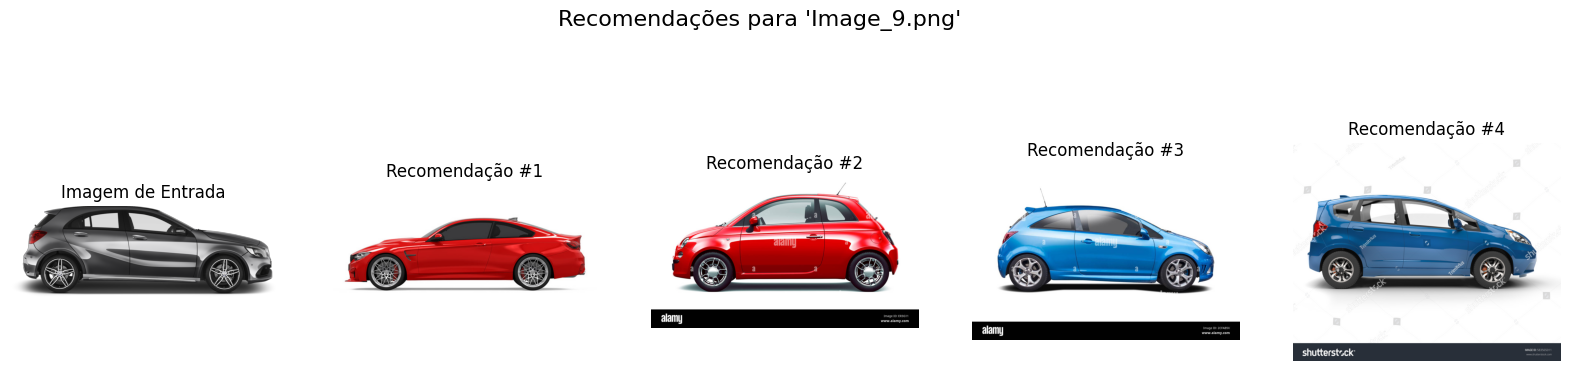


Buscando recomendações para 'Watches'...


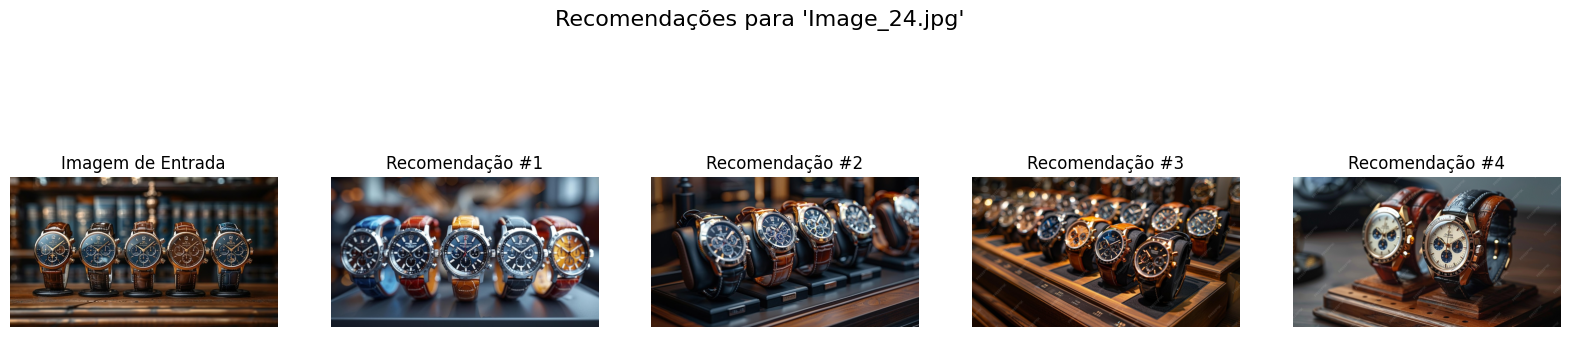


Buscando recomendações para 'Smartphones'...


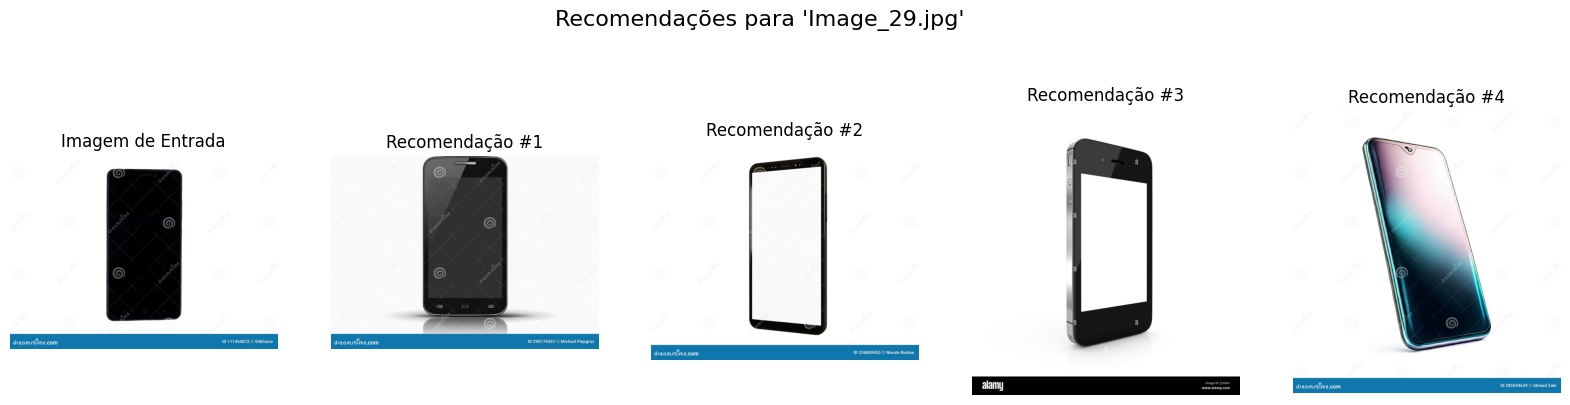


Buscando recomendações para 'Headphones'...


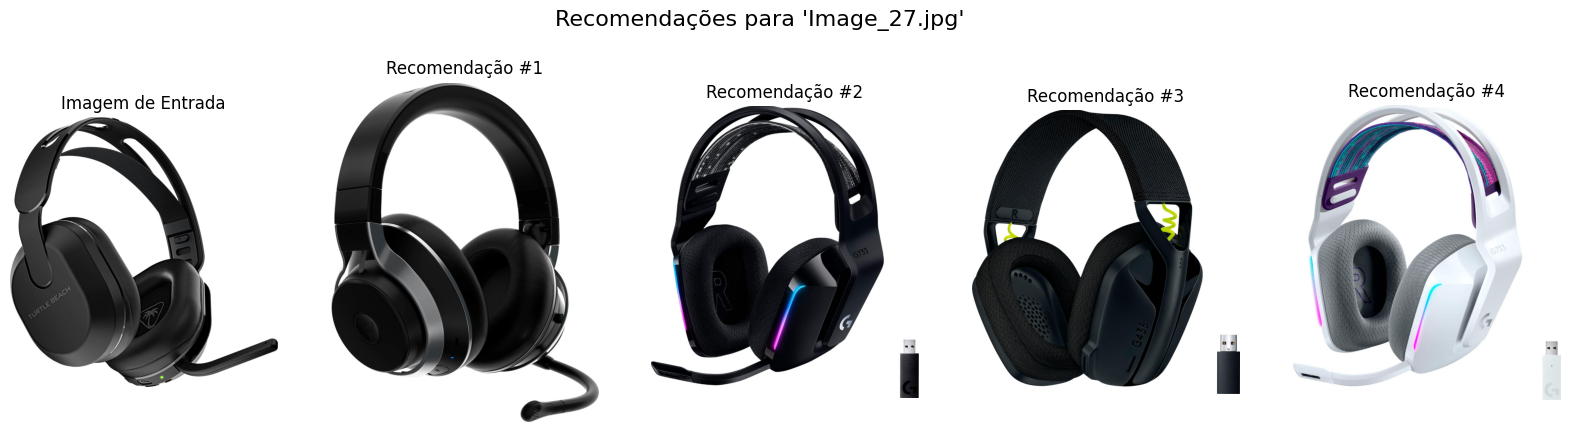



✅ PROJETO CONCLUÍDO!


In [7]:
print("Executando demonstrações para cada categoria")

for category in categories:
    if len(all_image_paths.get(category, [])) > 0:
        # Pega uma imagem aleatória da categoria para usar como exemplo
        test_image = random.choice(all_image_paths[category])
        recommend_similar_items(test_image, category)
    else:
        print(f"Nenhuma imagem encontrada para a categoria {category}. Pulando demonstração.")

print("\n\n✅ PROJETO CONCLUÍDO!")